In [10]:
#List of imports

import pandas as pd
import numpy as np
from scipy import stats
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import hmmlearn as hmm

import urllib.request
import zipfile
import cvxpy as cp
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import itertools

## Additions below
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVR
from sklearn.pipeline import make_pipeline
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler

In [11]:
from tqdm.notebook import tqdm
import warnings; warnings.simplefilter('ignore')

In [12]:
##Main

#Set up Data
price_data = pd.read_csv("../Data/sp500df.csv", index_col='Date')
rfr = pd.DataFrame({'risk_free': [0.01]*len(price_data.index)}, index = price_data.index)
data_set = Data(price_data, rfr,[i for i in range(20)])
data_set.set_factor_returns()

#Set Up Portfolio
num_stocks=data_set.get_num_stocks()
port= Portfolio(data_set)

#Set Up model
start_date = "2014-10-31"
end_date = "2017-11-01"
lookback = 20
lookahead = 2
lam = 0
trans_coeff = 0.1
holding_coeff = 0.1
conf_level = 0.99

# Define constraints to use
#constr_list = [ "asset_limit"]
constr_list = [ "cardinality", "asset_limit_cardinality"]
constr_model = Constraints(constr_list)

cost_model = Costs(trans_coeff, holding_coeff)
cost_model.replicate_cost_coeff(num_stocks, lookahead)

opt_model = Model(lam)
risk_model = Risks("MVO", conf_level)

regress_weighting = [0,0.5,0.5,0]
factor_model = FactorModel(lookahead, lookback, regress_weighting)

back_test_ex = Backtest(start_date, end_date, lookback, lookahead)
back_test_ex.run(data_set, port, factor_model, opt_model, constr_model, cost_model, risk_model)

port value period: [[0.02324776 0.02265383]
 [0.02253517 0.0225243 ]]
port return: 0.05000000000000001
risk value: 0.0005450177060802889
holding cost: 0.00019008693806161006
trans cost: 0.0011791458305806977
port value period: [[0.0245117  0.02229242]
 [0.02251275 0.02058266]]
port return: 0.05
risk value: 0.0005275889618969588
holding cost: 0.006050335734033884
trans cost: 0.0003960863091909608
port value period: [[0.02213141 0.02114441]
 [0.02215522 0.02163775]]
port return: 0.04999999999999999
risk value: 0.0005202111990304611
holding cost: 0.00990425241209447
trans cost: 0.0003735140066550691
port value period: [[0.01936355 0.02147127]
 [0.01989541 0.02319502]]
port return: 0.04999999999999999
risk value: 0.0005546044979473739
holding cost: 0.01347176065268562
trans cost: 0.0005647433782213449
port value period: [[0.0168228  0.02047231]
 [0.01761789 0.02235705]]
port return: 0.05
risk value: 0.0005245216660933997
holding cost: 0.016684674082685404
trans cost: 0.0006281590051285368


array([9.38555098])

In [8]:
port.weights[3].round(3)

array([ 0.048,  0.076,  0.056,  0.124,  0.017, -0.018,  0.065,  0.   ,
        0.056,  0.124,  0.039,  0.047,  0.   ,  0.   , -0.016, -0.021,
        0.067,  0.   ,  0.09 ,  0.   ,  0.245])

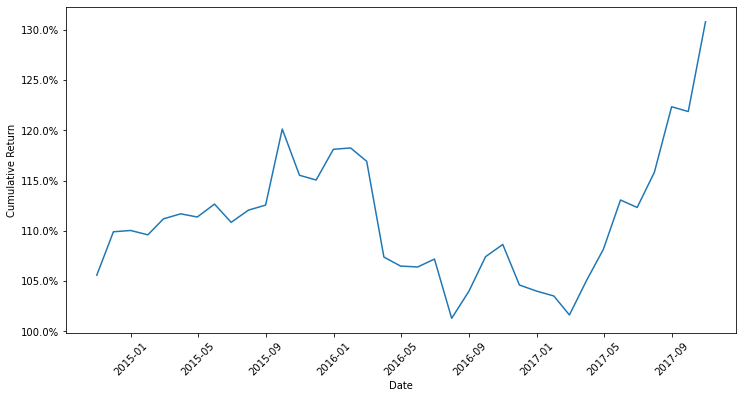

In [9]:
port.plot()

## Test


In [5]:
class Data:
    #Anything Data Related
    def __init__(self, stock_prices, risk_free, universe=None, period='M'):
        #TO-DO: Add initialization of market cap
        
        if not universe:
            universe = stock_prices.columns
            
        if type(universe[0])== int:
            self.stock_prices=stock_prices.iloc[:,universe]

        else:
            self.stock_prices=stock_prices[universe]
        
        self.risk_free = risk_free
        self.risk_free.index = pd.to_datetime(self.risk_free.index)
        self.risk_free = self.risk_free.resample(period).last()
        
        self.stock_prices.index= pd.to_datetime(self.stock_prices.index)
        self.factor_returns=None
        self.stock_returns=self.get_stock_returns()
        return
    
    def get_stock_returns(self, period='M'):
        price = self.stock_prices.resample(period).last()

        # Calculate the percent change
        ret_data = price.pct_change()[1:]

        # Convert from series to dataframe
        ret_data = pd.DataFrame(ret_data)
        
        return ret_data
    
    def set_factor_returns(self, factor_type='FF', period='M'):
        if factor_type == 'CAPM':
            self.factor_returns = self.get_CAPM_returns(period)
        
        elif factor_type == 'FF':
            self.factor_returns = self.get_FF_returns(period)
            
        elif factor_type == 'Carhart':
            self.factor_returns = self.get_Carhart_returns(period)
            
        elif factor_type == 'PCA':
            self.factor_returns = self.get_PCA_returns(period)
        
        else:
            print("Invalid input: Please select one of the following factor types: CAPM, FF, Carhart or PCA.")
        
        return   
    
    def get_FF_returns(self, period='M'):
        ff_url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_CSV.zip"    
        # Download the file and save it  
        urllib.request.urlretrieve(ff_url,'fama_french.zip')
        zip_file = zipfile.ZipFile('fama_french.zip', 'r')    
        # Extact the file data
        zip_file.extractall()
        zip_file.close()    
        ff_factors = pd.read_csv('F-F_Research_Data_Factors.csv', skiprows = 3, index_col = 0)   
        # Skip null rows
        ff_row = ff_factors.isnull().any(1).to_numpy().nonzero()[0][0]

        # Read the csv file again with skipped rows
        ff_factors = pd.read_csv('F-F_Research_Data_Factors.csv', skiprows = 3, nrows = ff_row, index_col = 0)

        # Format the date index
        ff_factors.index = pd.to_datetime(ff_factors.index, format= '%Y%m')

        # Format dates to end of month
        ff_factors.index = ff_factors.index + pd.offsets.MonthEnd()

        # Resample the data to correct frequency
        ff_factors = ff_factors.resample(period).last()

        # Convert from percent to decimal
        ff_factors = ff_factors.apply(lambda x: x/ 100)

        return ff_factors
    
    def get_CAPM_returns(self, period='M'):
        ff_factors = self.get_FF_returns(period)
        
        # Remove the unnecessary factors
        capm_factors = ff_factors.iloc[:, 0]
        
        return capm_factors
    
    def get_Carhart_returns(self, period='M'):
        ff_factors = self.get_FF_returns(period)

        # Get the momentum factor
        momentum_url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Momentum_Factor_CSV.zip"

        # Download the file and save it  
        urllib.request.urlretrieve(momentum_url,'momentum.zip')
        zip_file = zipfile.ZipFile('momentum.zip', 'r')

        # Extact the file data
        zip_file.extractall()
        zip_file.close()

        momentum_factor = pd.read_csv('F-F_Momentum_Factor.csv', skiprows = 13, index_col = 0)

        # Skip null rows
        row = momentum_factor.isnull().any(1).to_numpy().nonzero()[0][0]

        # Read the csv file again with skipped rows
        momentum_factor = pd.read_csv('F-F_Momentum_Factor.csv', skiprows = 13, nrows = row, index_col = 0)

        # Format the date index
        momentum_factor.index = pd.to_datetime(momentum_factor.index, format= '%Y%m')

        # Format dates to end of month
        momentum_factor.index = momentum_factor.index + pd.offsets.MonthEnd()

         # Resample the data to correct frequency
        momentum_factor = momentum_factor.resample(period).last()

        # Convert from percent to decimal
        momentum_factor = momentum_factor.apply(lambda x: x/ 100)

        # Combine to create the carhart_factors
        carhart_factors = pd.concat([ff_factors, momentum_factor], axis=1).dropna()

        return carhart_factors
    
    def get_PCA_returns(self, period='M'):
        exRets = self.get_stock_returns(period="D")
        num_stocks = len(exRets.columns)
        returns_mat = exRets.to_numpy()
        n_dates = returns_mat.shape[0]
        n_assets = returns_mat.shape[1]
        
        demeaned = (returns_mat - returns_mat.mean(axis=0)).transpose()
        sigma = 1/(n_dates - 1)*np.matmul(demeaned,demeaned.transpose())
        eigval, eigvec = np.linalg.eig(sigma)
        
        principal_components = np.matmul(eigvec.transpose(),demeaned).transpose()
        pca_factors = np.real(principal_components[:,0:100])
        
        pca_df = pd.DataFrame(pca_factors, index = exRets.index, columns = [str(i) for i in range(num_stocks)])
        pca_df = pca_df.resample(period).last()
        
        return pca_df
    
    def get_index_from_date(self, date_index_df, date):
        return date_index_df.index.get_loc(date)
    
    def get_lookback_data(self, date_index_df, date, lookback):
        end_idx= self.get_index_from_date(date_index_df, date)
        return date_index_df.iloc[end_idx-lookback:end_idx]      
    
    def get_num_stocks(self):
        return len(self.stock_returns.columns)

    
class Portfolio:
    #Anything Portfolio related: weights, returns, date-stamped
    def __init__(self, data):       
        num_stocks=data.get_num_stocks()
        #make weights have row, column
        #self.weights= np.expand_dims(np.array([0 for i in range(num_stocks)]),axis=0)
        
        self.weights= np.array([[0 for i in range(num_stocks)] + [1]]) # 0 weight on stock, 1 in risk-free market

        self.returns= np.array([])
        self.dates= []
   
        return
        
    def update_weights(self, new_weights):
        
        new_weights=np.expand_dims(new_weights,axis=0)    
        self.weights=np.append(self.weights,new_weights,axis=0)
        
        
        return
     
    def update_returns(self, new_returns):
        self.returns=np.append(self.returns, new_returns)
        return

    def update_dates(self, new_dates):
       
        self.dates.append(new_dates)
        return
        
    def get_Sharpe(self, data):
        risk_free=data.risk_free
        recent_date = self.dates[-1]
        sigma = np.std(self.returns - np.array(risk_free.loc[self.dates]))
        sharpe_ratio = ((np.prod(1+self.returns)-1) - np.array(risk_free.loc[recent_date]))/sigma
        return sharpe_ratio
        
    def plot(self):
        port_cumu_returns = np.array([x+1 for x in self.returns]).cumprod()
        plt.figure(figsize=(12,6))
        plt.plot(self.dates, port_cumu_returns)
        plt.xticks(rotation=45)
        plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
        plt.xlabel("Date")
        plt.ylabel("Cumulative Return")
        plt.show()
    

class Costs:
    def __init__(self, trans_coeff, holding_coeff):
        self.holding_cost = 0
        self.trans_cost = 0
        self.trans_coeff = trans_coeff
        self.holding_coeff = holding_coeff
        return
        
    def replicate_cost_coeff(self, num_stocks, lookahead):
        trans_cost_repl = np.ones((num_stocks,lookahead))/100
        holding_cost_repl = np.ones((num_stocks, lookahead))/100
        self.trans_coeff = trans_cost_repl*self.trans_coeff
        self.holding_coeff = holding_cost_repl*self.holding_coeff
        return
    
    def set_holding_cost(self, weights_new):
        self.holding_cost += cp.sum(cp.multiply(self.holding_coeff, cp.neg(weights_new)))
        return
        
    def calc_trans_cost(self, weights_new, weights_old, trans_coeff):
        abs_trade= cp.abs(weights_new-weights_old)
        return cp.sum(cp.multiply(trans_coeff, abs_trade))       
    
    
    def set_trans_cost(self, weights_new,weights_old):
        
        weights_curr= weights_new[:,0]
        if weights_new.shape[1]>1:         
            weights_future = weights_new[:,1:]
            weights_future_shift = weights_new[:,:-1]
            self.trans_cost = self.calc_trans_cost(weights_future, weights_future_shift, self.trans_coeff[:,1:])

        self.trans_cost += self.calc_trans_cost(weights_curr, weights_old,self.trans_coeff[:,0])
        return

    

class Constraints:
        #List of all constraints
        def __init__(self, constr_list=['cardinality','asset_limit_cardinality','no_short'], 
                     upper_limit=0.3 ,lower_limit=-0.3 ,stock_limit=15):
            self.upper_limit = upper_limit
            self.lower_limit = lower_limit
            self.stock_limit = stock_limit
            self.constr_list = constr_list
            self.value=[]

        
        def set_constraints(self, all_weights, y):
            # Set weight unity
            weights=all_weights[:-1,:]
            
            self.value += [cp.sum(all_weights,axis=0)==1]
            self.value += [all_weights[-1,:]>=0]
            
            if "cardinality" in self.constr_list:
                self.value+= [cp.sum(y,axis=0)== self.stock_limit]   
                
            if "no_short" in self.constr_list:
                self.value+=  [weights>=0]
                
            if "asset_limit_cardinality" in self.constr_list:
                cardinality_upper_limit= cp.multiply(self.upper_limit, y)
                cardinality_lower_limit = cp.multiply(self.lower_limit,y)
                self.value+=  [weights>=cardinality_lower_limit, weights<=cardinality_upper_limit]

            elif "asset_limit" in self.constr_list:
                self.value+=[weights<=self.upper_limit, weights>=self.lower_limit]
        
            return


class Risks:
    def __init__(self, risk_type="MVO", conf_lvl=0):
        self.value=0
        self.risk_type=risk_type
        self.conf_lvl=conf_lvl
        return
        
    def set_risk(self, weights, Q, lookahead):
        portfolio_risk=0
        robustness_cost=0
        num_stocks = weights.shape[1]
        
        for i in range(lookahead):
            portfolio_risk += cp.quad_form(weights[:,i],Q[i])        
        self.value = portfolio_risk
        
        if self.risk_type == "rect":
            for i in range(lookahead):
                delta = stats.norm.ppf(self.conf_lvl)*np.sqrt(np.diag(Q[i]/num_stocks))
                robustness_cost += delta@cp.abs(weights[:,i])
            self.value += robustness_cost
        
        elif self.risk_type == "ellip":
            for i in range(lookahead):
         
                penalty = cp.norm(np.sqrt(np.diag(Q[i]/num_stocks))@weights[:,i],2)
          
                robustness_cost += stats.chi2.ppf(self.conf_lvl, num_stocks)*penalty
            self.value += robustness_cost
            
        elif self.risk_type == "cvar":
            pass
        
        elif self.risk_type == 'B-L':
            self.value = 0
            pass
        
        return
    
    
class Model:
    def __init__(self, lam):
        self.opt_weights = 0
        self.status = None
        self.lam = lam

        return
        
    def MVO(self, port, mu , Q, rf, look_ahead, constr_model, cost_model, risk_model):
        
        mu_np = np.array(mu)
        Q_np = np.array(Q)
        
        num_stocks = port.weights.shape[1]-1
        
        #Construct optimization problem
        all_weights = cp.Variable((num_stocks+1,look_ahead))   
        y = cp.Variable((num_stocks,look_ahead), boolean=True)
        
        weights_prev= port.weights[-1,:-1]   
        weights=all_weights[:-1,:]
#         print(weights_prev.shape)
#         print(weights.shape)
        # Set model parameters
        cost_model.set_trans_cost(weights, weights_prev)
        cost_model.set_holding_cost(weights)    
        constr_model.set_constraints(all_weights, y)
        risk_model.set_risk(weights, Q,look_ahead)

        # Get portfolio return
        portfolio_return_per_period = mu_np@weights
        #rf_return = cp.sum(rf@rf_weight,)
        rf_return = cp.sum(rf*all_weights[-1,:])
        portfolio_return = cp.trace(portfolio_return_per_period)+rf_return
        
        #temp zero
#         cost_model.holding_cost=0
#         cost_model.trans_cost=0
#        objective= cp.Maximize(portfolio_return - self.lam*risk_model.value - cost_model.holding_cost - cost_model.trans_cost)
        objective= cp.Minimize(risk_model.value)
        constr_model.value+= [portfolio_return>=0.05]
        #Construct Problem and Solve
        prob= cp.Problem(objective, constr_model.value)
        result=prob.solve(solver="GUROBI")
        self.status= prob.status
        if self.status == "optimal":
            self.opt_weights=np.array(all_weights.value)[:,0]
            print("port value period:", portfolio_return_per_period.value)
            print("port return:",portfolio_return.value)
            print("risk value:",risk_model.value.value)
            print("holding cost:",cost_model.holding_cost.value)
            print("trans cost:", cost_model.trans_cost.value)
    
        else:
            print("Unsolvable, use old weights")
            self.opt_weights=port.weights[-1].T
     
        return self.opt_weights
        
    def BL(self):
        return
    
    
class Backtest:
    def __init__(self, start_date, end_date, lookback, lookahead):
        self.rebal_freq = 'M'
        self.start_date = start_date
        self.end_date = end_date
        self.lookback = lookback
        self.lookahead = lookahead
        self.reb_dates = None
        return
        
    
    def run(self, data, portfolio, factor_model, optimizer, constr_model, cost_model, risk_model):      
        stock_return= data.stock_returns      
        self.reb_dates= np.array(data.stock_returns.loc[self.start_date:self.end_date].index)    
        

        for t in self.reb_dates:
            mu, Q = factor_model.get_param_estimate(t, data)
            new_rf_rate=float(data.risk_free.loc[t])
   #         new_rf_weight=1.02
            if risk_model.risk_type in ('MVO', 'ellip', 'rect', 'cvar'):
                weights = optimizer.MVO(portfolio, mu , Q, new_rf_rate,self.lookahead, constr_model, cost_model, risk_model)     
            
            elif risk_model.risk_type == 'B-L':
                weights = optimizer.BL()
            
            portfolio.update_dates(t)
            portfolio.update_weights(weights)
            portfolio.update_returns(np.dot(weights[:-1],stock_return.loc[t])+weights[-1]*new_rf_rate)

            ##How the lambdas influence
            ##When to use MVO.. when to use CVaR... implement a CVaR

        return portfolio.get_Sharpe(data)


    def grid_search(self, data, trans_coeff, hold_coeff, lam):

        #         # Overall - currently test values are used in the Backtest2 class
        #         rebalance_freqs = ['M', '3M', '6M', '12M', '60M'] # Period in Data class
        #         pot_lookaheads = [1, 3, 6, 12, 60]
        #         pot_lookbacks = [2, 3, 6, 12, 60]

        #         # Factor Models
        #         factor_models = ['CAPM', 'FF', 'Carhart', 'PCA'] # Data
        #         regressions = ['linear', 'lasso', 'ridge', 'SVR'] # FactorModel

        #         # Constraints
        #         cardinalities = ['', 'cardinality']
        #         asset_limits = ['asset_limit_cardinality', 'asset_limit']
        #         no_shorts = ['', 'no_short']
        #         constraints_list = [weight_unities, cardinalities, asset_limits, no_shorts]

        #         stock_limits = list(range(5, 501, 5))

        #         # Optimization
        #         MVO_robustness = ['', 'rectangular', 'elliptical']

        # Overall
        pot_lookaheads = [5]
        pot_lookbacks = [20]

        # Factor Models
        factor_models = ['FF', 'PCA']  # Data
        #regressions = ['Linear', 'Lasso', 'Ridge', 'SVR'] # FactorModel
        regressions = [[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1],[0.25,0.25,0.25,0.25],
                       [0,0.5,0.5,0],[0,0.25,0.25,0.5],[0,0,0.5,0.5]]

        # Constraints
        cardinalities = ['cardinality']
        asset_limits = ['asset_limit_cardinality', 'asset_limit']
        no_shorts = ['no_short']
        constraints_list = [weight_unities, cardinalities, asset_limits, no_shorts]

        stock_limits = list(range(5, 21, 5))
        upper_asset_limits = [1]
        lower_asset_limits = [-1]

        # Optimization
        MVO_robustness = ['ellip']

        # list of sharpe ratios per parameter combination
        sharpe_ratios = []

        # list of parameter combinations corresponding to sharpe ratio
        parameter_combos = []

        for combo in tqdm(list(itertools.product(factor_models, regressions, \
                                                 list(itertools.product(*constraints_list)), stock_limits, \
                                                 upper_asset_limits, lower_asset_limits, MVO_robustness))):

            # Store the combination
            curr_combo = {'rebalance_freq': 'M', 'factor_model': combo[0], 'regression': combo[1],
                          'constraints_list': list(combo[2]), 'stock_limit': combo[3], 'upper_asset_limit': combo[4],
                          'lower_asset_limit': combo[5], 'robustness': combo[6]}

            # Initial Setup
            data.set_factor_returns(curr_combo['factor_model'], curr_combo['rebalance_freq'])

            num_stocks = len(data_set.stock_returns.columns)
            cost_model = Costs(trans_coeff, hold_coeff)

            initial_weights = [1 / num_stocks for i in range(num_stocks)]
            port = Portfolio(initial_weights)

            # Get lookaheads that are multiples of the rebalancing frequency and <= 60 months
            if curr_combo['rebalance_freq'] == 'M':
                first = 1
            else:
                first = int(curr_combo['rebalance_freq'][0])

            lookaheads = list(itertools.compress(pot_lookaheads, [look >= first for look in pot_lookaheads]))
            lookbacks = list(itertools.compress(pot_lookbacks, [look >= first for look in pot_lookbacks]))

            for lookahead in lookaheads:
                curr_combo['lookahead'] = lookahead
                for lookback in lookbacks:
                    curr_combo['lookback'] = lookback
#                     print(curr_combo)

                    # Continue Setup
                    cost_model.replicate_cost_coeff(num_stocks, lookahead)
                    constr_model = Constraints(curr_combo['constraints_list'], curr_combo['upper_asset_limit'], \
                                               curr_combo['lower_asset_limit'], curr_combo['stock_limit'])

                    opt_model = Model(lam) 
                    risk_model = Risks(curr_combo['robustness'], 0.95)

                    # Run backtest
                    factor = FactorModel(data_set, curr_combo['lookahead'], curr_combo['lookback'],
                                         curr_combo['regression'])
                    sharpe = self.run(data_set, port, factor, opt_model, constr_model, cost_model,
                                      curr_combo['lookahead'], risk_model)

                    # Update results
                    sharpe_ratios.append(sharpe)
                    parameter_combos.append(curr_combo)

        return sharpe_ratios, parameter_combos

In [6]:
class FactorModel:
    def __init__(self, lookahead, lookback, regress_weighting):
        
        """
        lookahead: number of periods in the future to estimate
        lookback: number of periods in the past to use for estimations
        regress_weighting: array of size 4 with weight corresponding to each regression type; adds up to 1; 
        order is linear, lasso, ridge, SVR; in the case where there is one 1 and the rest 0's, there is no ensembling;
        can artifically call LSTM by setting all weights to 0
        """
        self.lookahead = lookahead
        self.lookback = lookback
        self.regress_weighting = regress_weighting
        return
               
    def get_param_estimate(self, rebal_date, data):
               
        if sum(self.regress_weighting) == 0:
            return self.get_mu_LSTM(rebal_date, data)

        elif sum(self.regress_weighting) == 1:
            return self.get_mu_Q_regression(rebal_date, data)
        
        else:
            return "ERROR: This regression weighting is not valid. Please make sure the weights sum to 1. You can also give all zeros for LSTM."
        
    def get_mu_Q_regression(self, rebal_date, data): 
        returns_data = data.stock_returns
        factor_data = data.factor_returns
        lookahead = self.lookahead
        lookback = self.lookback
        regress_weighting = self.regress_weighting
                
        # For keeping track of mu's and Q's from each period
        mu_arr = []
        Q_arr = []

        n_factors = len(factor_data.columns)

        returns_data = data.get_lookback_data(returns_data, rebal_date, lookback)
        factor_data = data.get_lookback_data(factor_data, rebal_date, lookback)
        
        for i in range(0, lookahead):

            # Calculate the factor covariance matrix
            F = factor_data.loc[:, factor_data.columns != 'Ones'].cov()

            # Calculate the factor expected excess return from historical data using the geometric mean
            factor_data['Ones'] = [1 for i in range(len(factor_data))]
            gmean = stats.gmean(factor_data + 1,axis=0) - 1

            # Set up X and Y to determine alpha and beta
            X = factor_data
            Y = returns_data
            X = X.to_numpy()
            Y = Y.to_numpy()

            
            ### LINEAR REGRESSION
        
            model = LinearRegression().fit(X,Y)
            alpha = model.intercept_
            beta = model.coef_[:,0:n_factors]

            # Calculate the residuals 
            alpha = np.reshape(alpha,(alpha.size,1))
            epsilon = returns_data.to_numpy() - np.matmul(X, np.transpose(np.hstack((beta, alpha))))

            # Calculate the residual variance with "N - p - 1" degrees of freedom
            sigmaEp = np.sum(epsilon**2, axis=0) / (len(returns_data) - n_factors - 1)

            #  Calculate the asset expected excess returns
            mu_linear = model.predict([gmean])[0]

            # Calculate the diagonal matrix of residuals and the asset covariance matrix
            D = np.diag(sigmaEp)

            # Calculate the covariance matrix
            Q_linear = np.matmul(np.matmul(beta,F.to_numpy()),beta.T)+D


            ### LASSO REGRESSION

            model = Lasso().fit(X,Y)
            alpha = model.intercept_
            beta = model.coef_[:,0:n_factors]

            # Calculate the residuals 
            alpha = np.reshape(alpha,(alpha.size,1))
            epsilon = returns_data.to_numpy() - np.matmul(X, np.transpose(np.hstack((beta, alpha))))

            # Calculate the residual variance with "N - p - 1" degrees of freedom
            sigmaEp = np.sum(epsilon**2, axis=0) / (len(returns_data) - n_factors - 1)

            #  Calculate the asset expected excess returns
            mu_lasso = model.predict([gmean])[0]

            # Calculate the diagonal matrix of residuals and the asset covariance matrix
            D = np.diag(sigmaEp)

            # Calculate the covariance matrix
            Q_lasso = np.matmul(np.matmul(beta,F.to_numpy()),beta.T)+D


            ### RIDGE REGRESSION

            model = Ridge().fit(X,Y)
            alpha = model.intercept_
            beta = model.coef_[:,0:n_factors]

            # Calculate the residuals 
            alpha = np.reshape(alpha,(alpha.size,1))
            epsilon = returns_data.to_numpy() - np.matmul(X, np.transpose(np.hstack((beta, alpha))))

            # Calculate the residual variance with "N - p - 1" degrees of freedom
            sigmaEp = np.sum(epsilon**2, axis=0) / (len(returns_data) - n_factors - 1)

            #  Calculate the asset expected excess returns
            mu_ridge = model.predict([gmean])[0]

            # Calculate the diagonal matrix of residuals and the asset covariance matrix
            D = np.diag(sigmaEp)

            # Calculate the covariance matrix
            Q_ridge = np.matmul(np.matmul(beta,F.to_numpy()),beta.T)+D


            ### SUPPORT VECTOR REGRESSION

            model = make_pipeline(StandardScaler(), MultiOutputRegressor(LinearSVR(C=1, dual=False, loss="squared_epsilon_insensitive"))).fit(X, Y)
            beta = np.array([[model.named_steps['multioutputregressor'].estimators_[i].coef_[0:n_factors] for i in range(len(model.named_steps['multioutputregressor'].estimators_))]])[0]
            alpha = np.array([model.named_steps['multioutputregressor'].estimators_[i].intercept_[0] for i in range(len(model.named_steps['multioutputregressor'].estimators_))])

            # Calculate the residuals 
            alpha = np.reshape(alpha,(alpha.size,1))
            epsilon = returns_data.to_numpy() - np.matmul(X, np.transpose(np.hstack((beta, alpha))))

            # Calculate the residual variance with "N - p - 1" degrees of freedom
            sigmaEp = np.sum(epsilon**2, axis=0) / (len(returns_data) - n_factors - 1)

            #  Calculate the asset expected excess returns
            mu_SVR = model.predict([gmean])[0]

            # Calculate the diagonal matrix of residuals and the asset covariance matrix
            D = np.diag(sigmaEp)

            # Calculate the covariance matrix
            Q_SVR = np.matmul(np.matmul(beta,F.to_numpy()),beta.T)+D

        
            # Ensemble the methods
            mu = regress_weighting[0]*mu_linear + regress_weighting[1]*mu_lasso + regress_weighting[2]*mu_ridge + regress_weighting[3]*mu_SVR
            Q = regress_weighting[0]*Q_linear + regress_weighting[1]*Q_lasso + regress_weighting[2]*Q_ridge + regress_weighting[3]*Q_SVR

            # Add mu and Q to array
            mu_arr.append(mu)
            Q_arr.append(Q)

            # Update for next time step
            factor_data = factor_data[1:]
            factor_append = pd.Series(gmean, index = factor_data.columns)
            factor_data = factor_data.append(factor_append, ignore_index=True)

            returns_data = returns_data[1:]
            mu_append = pd.Series(mu, index=returns_data.columns)
            returns_data = returns_data.append(mu_append, ignore_index=True)   

        return mu_arr, Q_arr
        
    def get_mu_LSTM(self, rebal_date, data): 
        returns_data = data.stock_returns
        factor_data = data.factor_returns
        
        lookahead = self.lookahead
        lookback = self.lookback
        regress_weighting = self.regress_weighting

        returns_data = data.get_lookback_data(returns_data, rebal_date, lookback)
        factor_data = data.get_lookback_data(factor_data, rebal_date, lookback)
        
        tempx, tempy = self.generate_X_y(factor_data.values, returns_data.values, lookback, lookahead)
        train_x, test_x, train_y, test_y = self.traintest_split(tempx, tempy)

        # scale inputs
        scaled_train_x = (train_x - train_x.min())/(train_x.max() - train_x.min())
        scaled_test_x = (test_x - test_x.min())/(test_x.max() - test_x.min())
        scaled_train_y = (train_y - train_y.min())/(train_y.max() - train_y.min())
        scaled_test_y = (test_y - test_y.min())/(test_y.max() - test_y.min())

        mu = self.get_prediction(train_x, train_y, factor_data, lookback)
        return mu
    
    def generate_X_y(self, factor_data, returns_data, n_lookback, n_lookforward):
        X, y = list(), list()
        in_start = 0
        for i in range(len(factor_data)):
            in_end = in_start + n_lookback
            out_end = in_end + n_lookforward
            # ensure we have enough data for this instance
            if out_end <= len(factor_data):
                X.append(factor_data[in_start:in_end,:])
                y.append(returns_data[in_end:out_end,:])
            in_start += 1
        return np.array(X), np.array(y)
    
    def traintest_split(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        return X_train, X_test, y_train, y_test   
    
    def build_model(self, train_x, train_y):
        # define parameters
        verbose, epochs, batch_size = 0, 50, 16
        n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]

        # define model
        model = Sequential()
        model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
        model.add(RepeatVector(n_outputs))
        model.add(LSTM(200, activation='relu', return_sequences=True))
        model.add(TimeDistributed(Dense(100, activation='relu')))
        model.add(TimeDistributed(Dense(train_y.shape[2])))
        model.compile(loss='mse', optimizer='adam')
        # fit network
        model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
        return model
    
    def forecast(self, model, history, n_lookback):
        # flatten data
        data = np.array(history)
        data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
        # retrieve last observations for lookback data
        input_x = data[-n_lookback:, :]
        # reshape into [1, n_lookback, n]
        input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
        # forecast the next set
        yhat = model.predict(input_x, verbose=0)
        # we only want the vector forecast
        yhat = yhat[0]
        return yhat

    def evaluate_forecasts(self, actual, predicted):
        # calculate overall RMSE
        s = 0
        for row in range(actual.shape[0]):
            for col in range(actual.shape[1]):
                for k in range(actual.shape[2]):
                    s += (actual[row, col, k] - predicted[row, col, k])**2
        score = sqrt(s / (actual.shape[0] * actual.shape[1] * actual.shape[2]))
        return score

    def evaluate_model(self, train_x, train_y, test_x, test_y, n_lookback):
        # fit model
        model = self.build_model(train_x, train_y)
        history = [x for x in train_x]
        # walk-forward validation 
        predictions = list()
        for i in range(len(test_x)):
            yhat_sequence = self.forecast(model, history, n_lookback)
            # store the predictions
            predictions.append(yhat_sequence)
            # get real observation and add to history for predicting the next set
            history.append(test_x[i, :])
        # evaluate predictions 
        predictions = np.array(predictions)
        score = self.evaluate_forecasts(test_y, predictions)
        plt.plot(model.history.history['loss'])
        #plt.plot(model.history.history['val_loss'])
        return score
    
    def get_prediction(self, train_x, train_y, factor_data, lookback):
        model = self.build_model(train_x, train_y)
        return self.forecast(model, factor_data.tail(lookback), lookback)


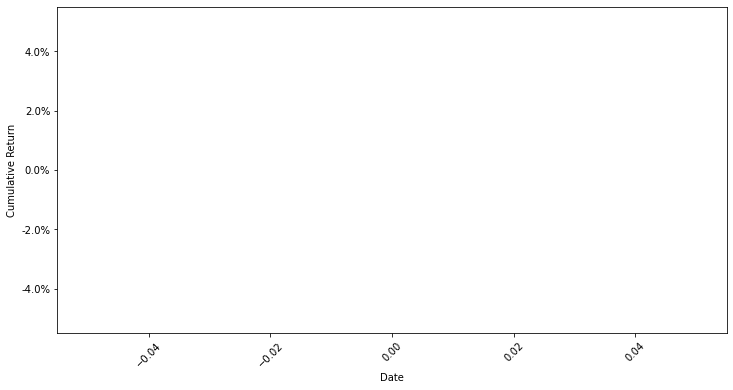

In [6]:
port.plot()

In [7]:
rebal_freq="M"
start_date= "2014-10-31"
end_date= "2017-11-01"
lookback=20
lookahead=5
lam=0.9
trans_coeff=0.2
holding_coeff=0.2

test = Backtest(rebal_freq, start_date, end_date, lookback, lookahead)
test.grid_search(price_data,[i for i in range(20)], trans_coeff, holding_coeff, lam)

TypeError: __init__() takes 5 positional arguments but 6 were given

In [8]:
a=data_set.stock_returns.index[0]
print(a)

2010-12-31 00:00:00


In [9]:
    
    class Regime:
        def __init__(self, data ,t):
            train_data=None
            train_dates=None
            self.get_train_data(data,t)
            
        def get_train_data(self, data, t):
            mkt_data = data.factor_returns["Mkt-RF"]+data_set.factor_returns["RF"]
            first_date="2019-01-01"
            mkt_returns=mkt_data[first_date:t]
            self.train_dates=mkt_returns.index
            
            mkt_returns=np.array(mkt_returns.values)
            mkt_prices = 100*(np.array([x+1 for x in mkt_returns]).cumprod())
            mkt_prices=np.expand_dims(mkt_prices,axis=1)
            self.train_data= mkt_prices
            
            
        def HMM (self, num_hs):
            model=hmm.GaussianHMM(n_components=num_hs)
            model.fit(self.train_data)
            return model
            

In [294]:
t="2019-12-31"
reg=Regime(data_set,t)
reg_model =reg.HMM(2)

In [295]:
reg_model.means_

array([[122.08735281],
       [113.57296098]])

In [296]:
out=reg_model.predict(reg.train_data)

In [297]:
test=np.array(list(map(bool,out)))

In [298]:
reg_model.means_

array([[122.08735281],
       [113.57296098]])

Text(0, 0.5, 'Cumulative Return')

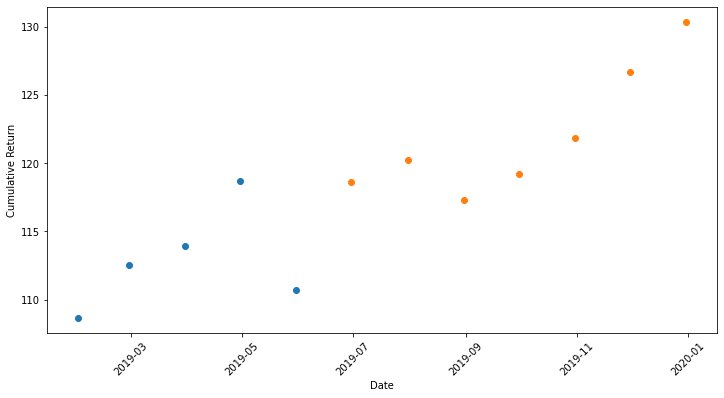

In [299]:


        plt.figure(figsize=(12,6))
        plt.scatter(reg.train_dates[test],reg.train_data[test])
        plt.scatter(reg.train_dates[~test],reg.train_data[~test])

        plt.xticks(rotation=45)
        #plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
        plt.xlabel("Date")
        plt.ylabel("Cumulative Return")
        

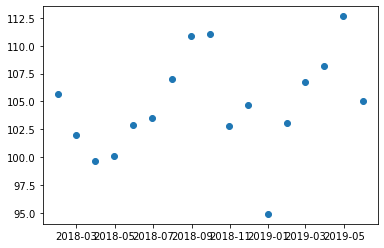

In [292]:
plt.scatter(reg.train_dates[~test],reg.train_data[~test])

In [281]:
reg.train_dates[test]

DatetimeIndex(['2008-01-31', '2008-02-29', '2008-03-31', '2008-04-30',
               '2008-05-31', '2008-06-30', '2008-07-31', '2008-08-31',
               '2008-09-30', '2008-10-31', '2008-11-30', '2008-12-31',
               '2009-01-31', '2009-02-28', '2009-03-31', '2009-04-30',
               '2009-05-31', '2009-06-30', '2009-07-31', '2009-08-31',
               '2009-09-30', '2009-10-31', '2009-11-30', '2009-12-31',
               '2010-01-31', '2010-02-28', '2010-03-31', '2010-04-30',
               '2010-05-31', '2010-06-30', '2010-07-31', '2010-08-31',
               '2010-09-30', '2010-10-31', '2010-11-30', '2010-12-31',
               '2011-01-31', '2011-02-28', '2011-03-31', '2011-04-30',
               '2011-05-31', '2011-06-30', '2011-07-31', '2011-08-31',
               '2011-09-30', '2011-10-31', '2011-11-30', '2011-12-31',
               '2012-01-31', '2012-02-29', '2012-03-31', '2012-04-30',
               '2012-05-31', '2012-06-30', '2012-07-31', '2012-08-31',
      